In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

# Seed for random state
seed = 42
torch.manual_seed(seed)

# Load housing dataset
housing_dataset = pd.read_csv('./../data/Housing.csv', delimiter=',')

# Prepare the dataset.

# List of variable to map to numerical values.
varlist = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

# Applying the function to the housing list
housing_dataset[varlist] = housing_dataset[varlist].apply(binary_map)

# preview the dataset
housing_dataset.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [2]:
# Extract the desired features
filter = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']

housing_filtered = housing_dataset[filter]
housing_filtered.head()

,area,bedrooms,bathrooms,stories,parking,price
0,7420,4,2,3,2,13300000
1,8960,4,4,4,3,12250000
2,9960,3,2,2,2,12250000
3,7500,4,2,2,3,12215000
4,7420,4,1,2,2,11410000


In [3]:
# array of data
data = housing_filtered.values
data.shape

(545, 6)

In [4]:
# Generate random indices for training and validation data.
n_samples = data.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

# Transform data to a tensor
torch_data = torch.tensor(data, dtype=torch.float32)

# Filter the train and val subsets from the dataset
torch_train_data = torch_data[train_indices]
torch_val_data = torch_data[val_indices]

In [5]:
# Convert train and val tensors to numpy arrays
np_train_data = torch_train_data.numpy()
np_val_data = torch_val_data.numpy()
print(np_train_data.shape)
print(np_val_data.shape)

# Normalize the train and val subsets using the MinMaxScaler
sc_nn =  MinMaxScaler()
t_n_train = torch.from_numpy(sc_nn.fit_transform(np_train_data)).float()
t_n_val = torch.from_numpy(sc_nn.transform(np_val_data)).float()

(436, 6)
(109, 6)


In [6]:
# Filter features and targets for training and validation.
t_un_train = t_n_train[:, :-1]
t_cn_train = t_n_train[:, -1].unsqueeze(1)

t_un_val = t_n_val[:, :-1]
t_cn_val = t_n_val[:, -1].unsqueeze(1)

print(t_un_train.dtype, t_un_val.dtype)
t_un_train.shape, t_cn_train.shape, t_un_val.shape, t_cn_val.shape

torch.float32 torch.float32


(torch.Size([436, 5]),
 torch.Size([436, 1]),
 torch.Size([109, 5]),
 torch.Size([109, 1]))

In [7]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear_1', nn.Linear(5, 8)),
    ('hidden_activation_1', nn.ReLU()),
    ('hidden_linear_2', nn.Linear(8, 100)),
    ('hidden_activation_2', nn.ReLU()),
    ('hidden_linear_3', nn.Linear(100, 8)),
    ('hidden_activation_3', nn.ReLU()),
    ('output_linear', nn.Linear(8, 1))
]))

In [8]:
import time

loss_train_list = []
loss_val_list = []
epochs_list = []

def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    
    duration = []
    training_start_time = time.time()

    for epoch in range(1, n_epochs+1):
        
        t0 = time.time()

        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        duration.append(time.time() - t0)

        if epoch == 1 or epoch % 50 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}, Time(s) {np.mean(duration):.5f}")
            loss_train_list.append(loss_train.item())
            loss_val_list.append(loss_val.item())
            epochs_list.append(epoch)
    print(f'Training finished, took {time.time() - training_start_time:.5f} seconds')

In [9]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 200, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_cn_train,
    t_c_val = t_cn_val)

Epoch 1, Training loss 0.1786, Validation loss 0.1753, Time(s) 0.00500
Epoch 50, Training loss 0.1429, Validation loss 0.1392, Time(s) 0.00138
Epoch 100, Training loss 0.1165, Validation loss 0.1122, Time(s) 0.00131
Epoch 150, Training loss 0.0980, Validation loss 0.0936, Time(s) 0.00128
Epoch 200, Training loss 0.0844, Validation loss 0.0797, Time(s) 0.00124
Training finished, took 0.24927 seconds


In [10]:
model = seq_model
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.4f}MB'.format(size_all_mb))

model size: 0.0067MB


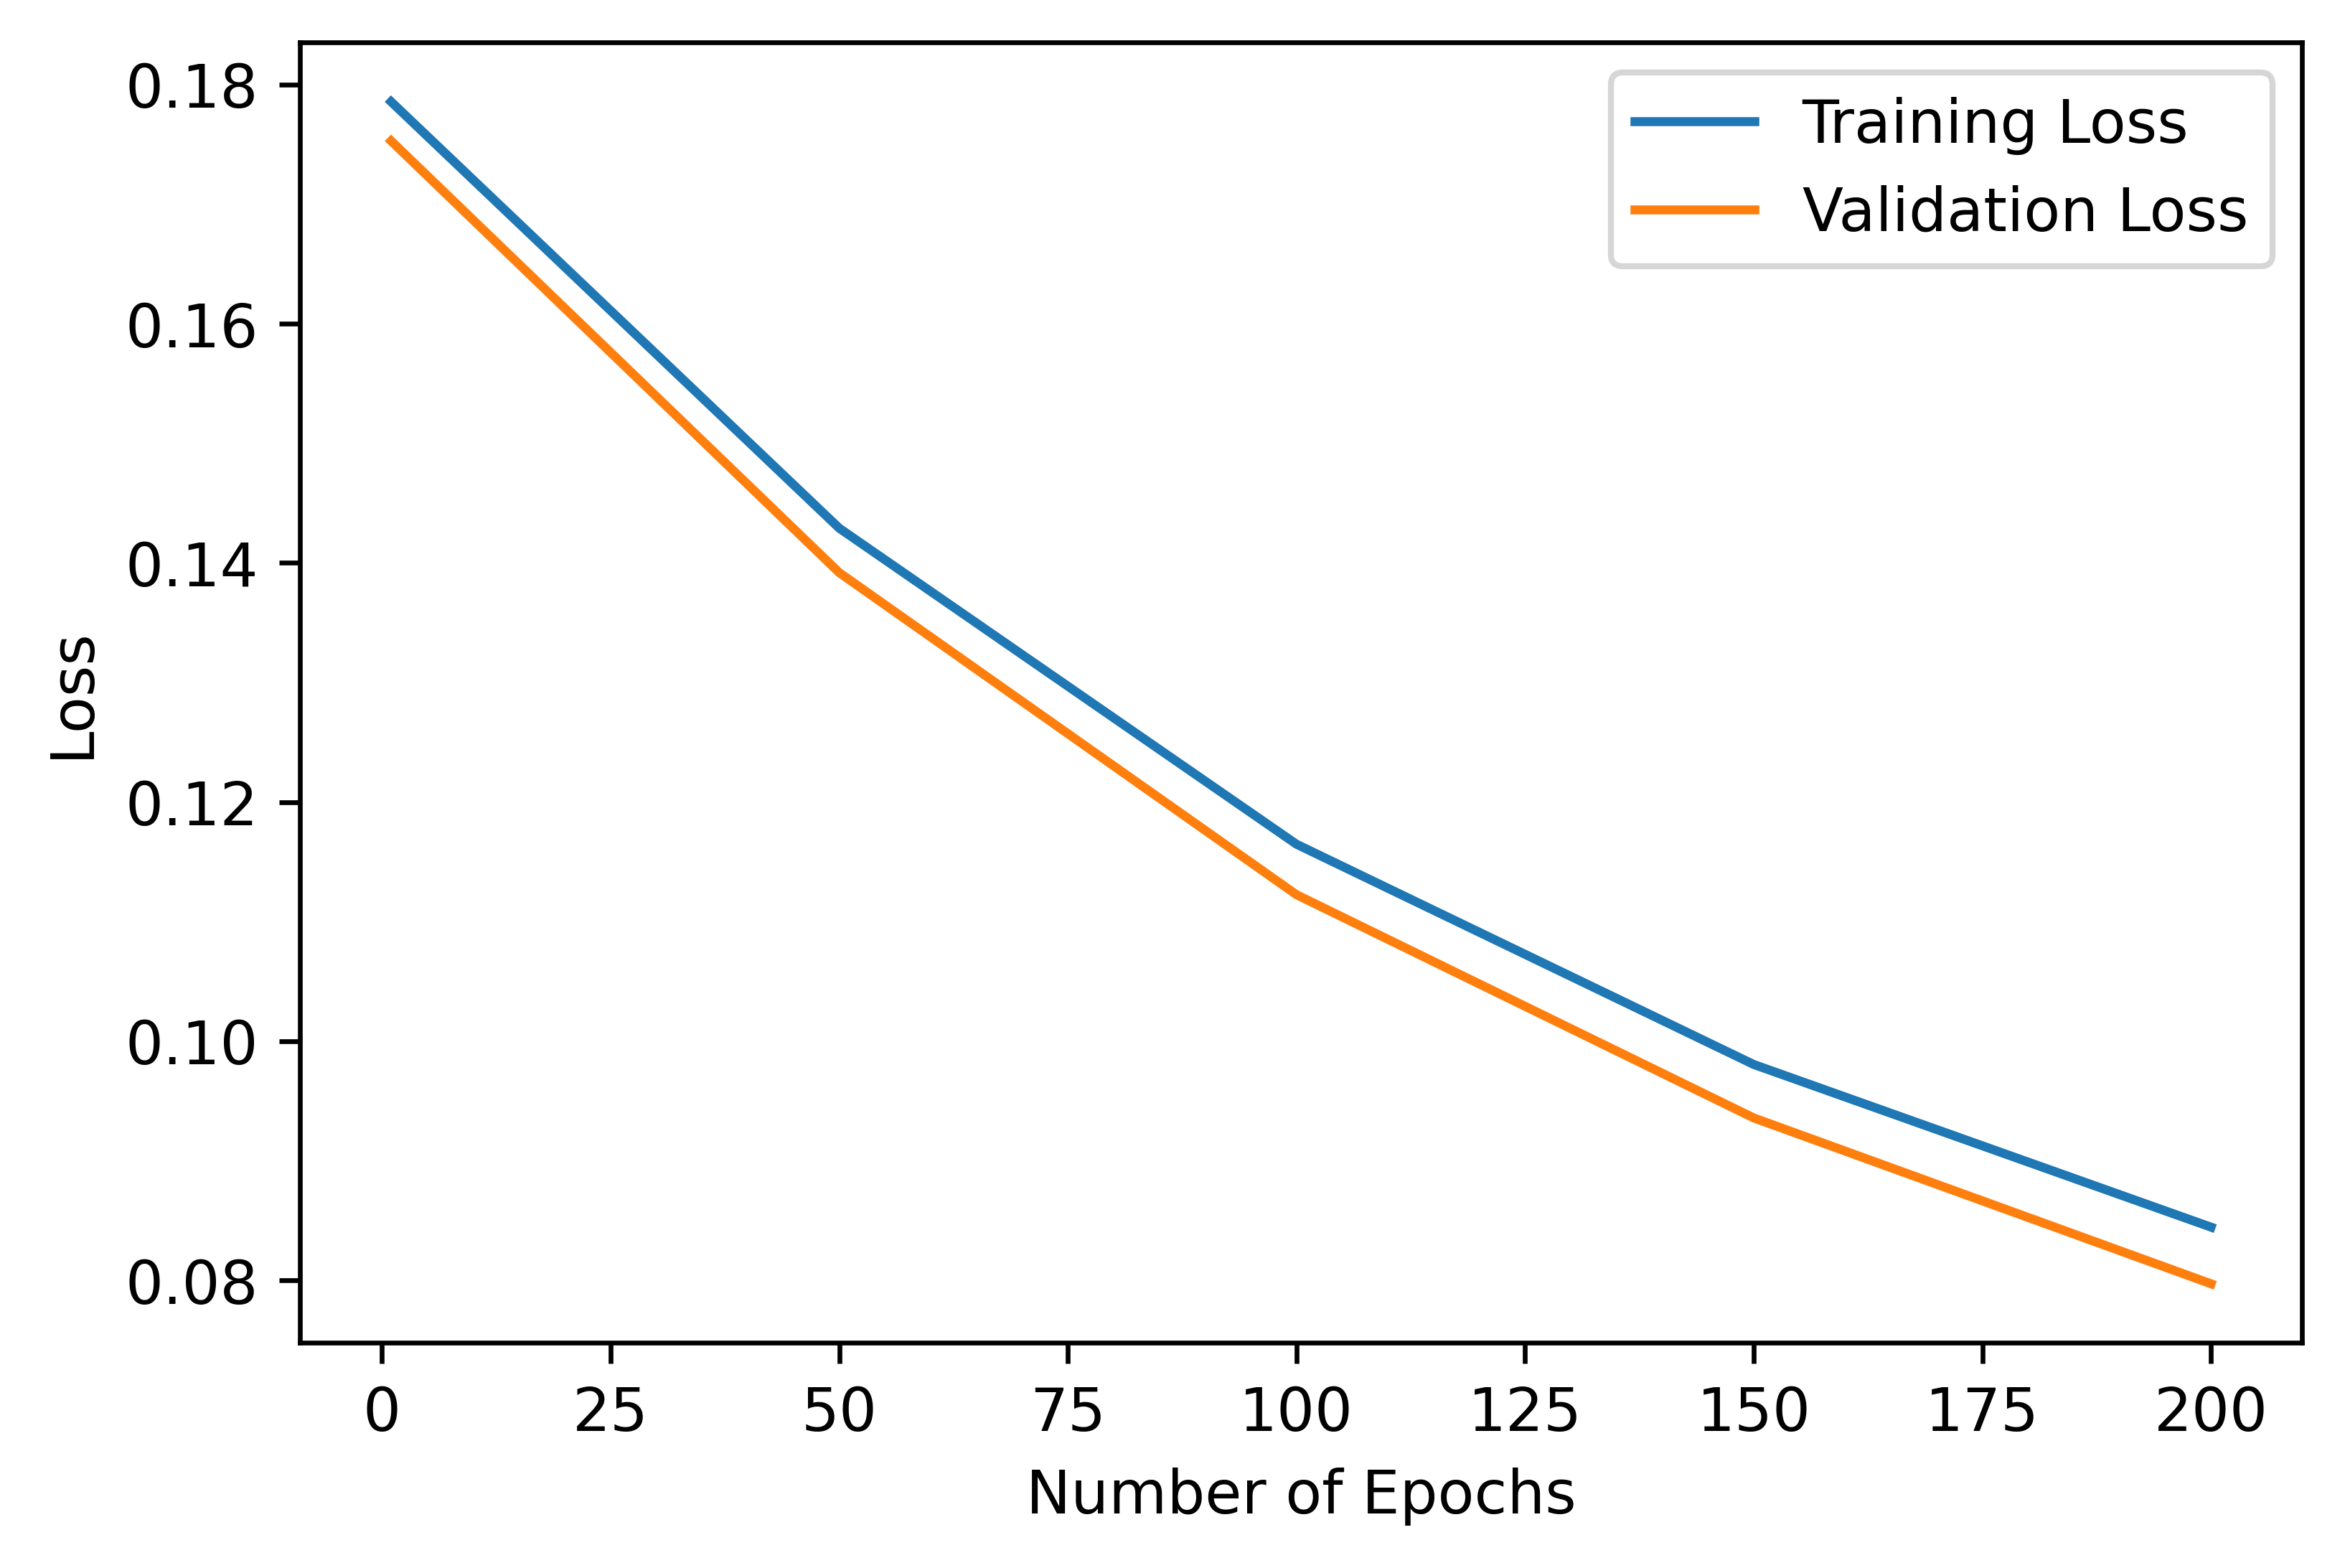

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(dpi=600)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.plot(epochs_list, loss_train_list, label="Training Loss")
plt.plot(epochs_list, loss_val_list, label="Validation Loss")
plt.legend()
plt.savefig("nn_3_hidden.png", format="png")